In [1]:
!pip install git+https://github.com/imanring/BSTPP.git

  Cloning https://github.com/imanring/BSTPP.git to /tmp/pip-req-build-8fn6ork4
  Running command git clone --filter=blob:none --quiet https://github.com/imanring/BSTPP.git /tmp/pip-req-build-8fn6ork4
  Resolved https://github.com/imanring/BSTPP.git to commit 54ac69a7a37699f164584f3761973062fc9e7653
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for BSTPP, since package 'wheel' is not installed.
  Running setup.py install for BSTPP ... done


In [1]:
from bstpp.main import Point_Process_Model
import numpyro.distributions as dist
import numpy as np

In [2]:
A = np.array([[3,15.5],[4,16.5]])
column_names = ['droughtstart_speibase', 'urban_ih_log', 'droughtyr_speigdm',
       'herb_gc', 'capdist', 'grass_ih_log', 'nlights_sd_log', 'water_gc_log',
       'pop_gpw_sd_log', 'pasture_ih']
model_name = 'cox_hawkes'
model = Point_Process_Model('data/spt_data.csv',A,model=model_name,
                            spatial_cov='data/inc_spatial_cov.csv',cov_grid_size=(0.5,0.5),
                            cov_names = column_names,
                            a_0=dist.Normal(0,5))

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:167: UserWarning: `keep_geom_type=True` in overlay resulted in 4466 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersect = gpd.overlay(comp_grid, spatial_cov, how='intersection')


In [3]:
import sys
from bstpp import inference_functions
from bstpp import utils
sys.modules['inference_functions'] = inference_functions
sys.modules['utils'] = utils

import pickle
pre_run = False
if pre_run:
    with open(f'output/{model_name}/output.pkl', 'rb') as f:
        output = pickle.load(f)
    model.mcmc = output['mcmc']
    model.mcmc_samples = output['samples']
else:
    model.run_mcmc(output_file=f'output/{model_name}/output.pkl')

sample: 100%|███████████████████████████| 1500/1500 [00:25<00:00, 59.55it/s, 255 steps of size 1.61e-02. acc. prob=0.94]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0     -3.98      0.58     -3.99     -4.96     -3.03    337.80      1.00
          w[0]     -0.03      0.07     -0.03     -0.15      0.08    938.77      1.00
          w[1]     -0.20      0.03     -0.20     -0.25     -0.14    715.97      1.00
          w[2]     -0.10      0.02     -0.10     -0.14     -0.06    790.68      1.00
          w[3]     -1.98      0.08     -1.98     -2.11     -1.86    888.40      1.00
          w[4]      0.34      0.03      0.34      0.29      0.40    702.90      1.00
          w[5]      0.81      0.03      0.81      0.75      0.86   1191.99      1.00
          w[6]      0.97      0.04      0.96      0.89      1.02    792.22      1.00
          w[7]     -1.08      0.04     -1.08     -1.14     -1.01    891.72      1.00
          w[8]      1.93      0.06      1.93      1.85      2.03    775.50      1.00
          w[9]      0.78      0.03      0.78      0.73      0.84

In [4]:
model.args['int_df']['cov_ind']

0       19
1        0
2       20
3        1
4       21
      ... 
734    604
735    605
736    606
737    607
738    607
Name: cov_ind, Length: 739, dtype: int64

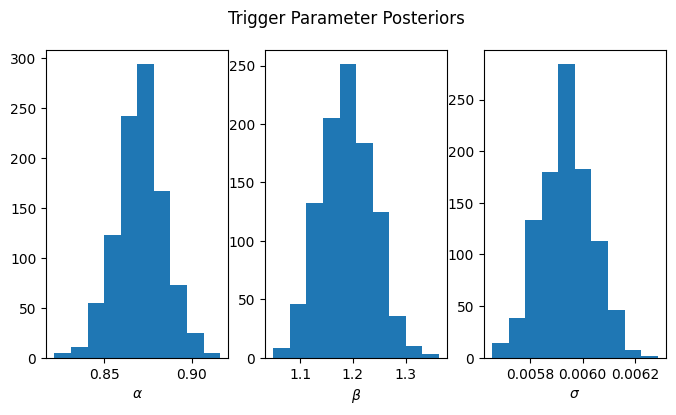

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.870496,0.013849,62.856499,0.0,0.842133,0.898320
beta,1.189651,0.049245,24.157925,0.0,1.096381,1.288942
sigma,0.005938,0.000097,60.929134,0.0,0.005750,0.006124


In [4]:
model.plot_trigger_posterior(f'output/{model_name}/trig_post.png')

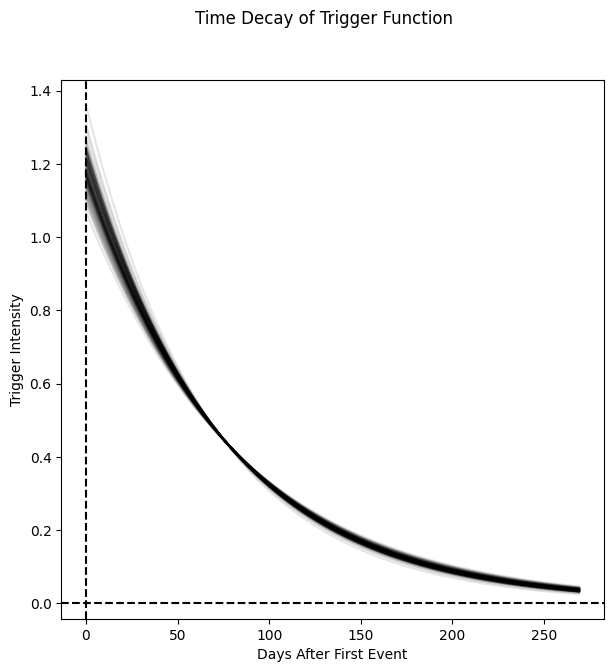

Mean trigger time: 76.9 days


In [5]:
model.plot_trigger_time_decay(f'output/{model_name}/trig_post_time_decay.png')

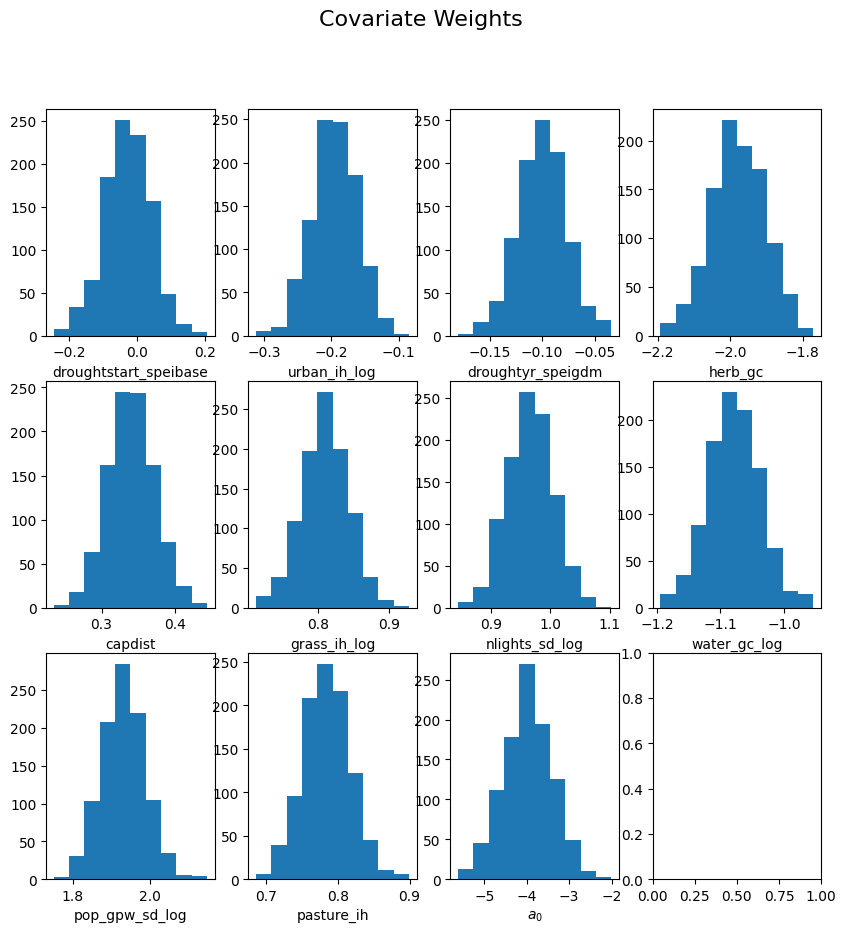

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,-0.027529,0.068786,-0.400216,6.889978e-01,-0.167731,0.104370
urban_ih_log,-0.195653,0.033785,-5.791104,6.992508e-09,-0.262904,-0.131323
droughtyr_speigdm,-0.100009,0.022957,-4.356298,1.322807e-05,-0.146331,-0.055114
herb_gc,-1.977565,0.075042,-26.352718,0.000000e+00,-2.132754,-1.831385
capdist,0.340446,0.031569,10.784062,0.000000e+00,0.280031,0.404663
grass_ih_log,0.809417,0.033517,24.149139,0.000000e+00,0.745084,0.875955
nlights_sd_log,0.965994,0.038670,24.980358,0.000000e+00,0.894468,1.043710
water_gc_log,-1.078806,0.041131,-26.228283,0.000000e+00,-1.158372,-0.997452
pop_gpw_sd_log,1.931892,0.056328,34.297447,0.000000e+00,1.820547,2.044777
pasture_ih,0.784369,0.032869,23.863346,0.000000e+00,0.722136,0.849479


In [7]:
model.cov_weight_post_summary(plot_file=f'output/{model_name}/cov_post_hist.png',
                              summary_file=f'output/{model_name}/cov_par_summary.csv')

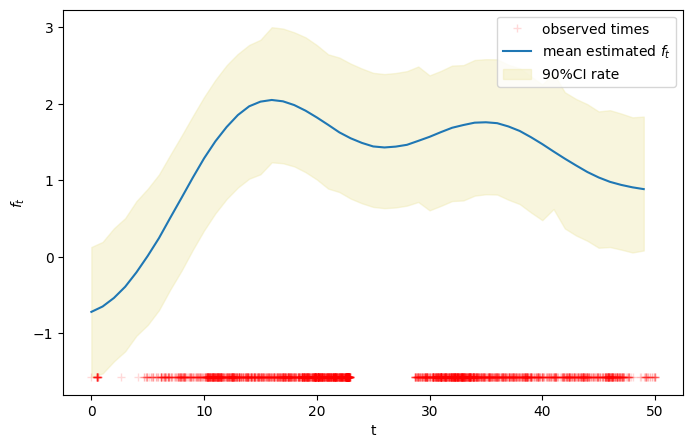

In [6]:
model.plot_temporal_background(f'output/{model_name}/temporal_gp_post_mean.png')

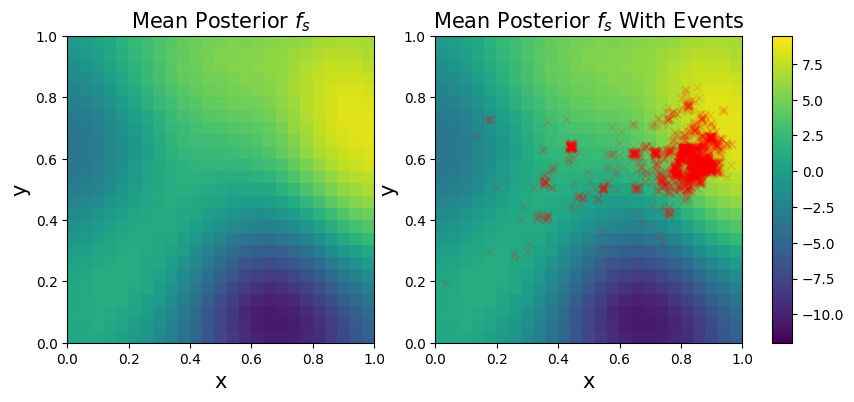

In [4]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_post_mean.png')

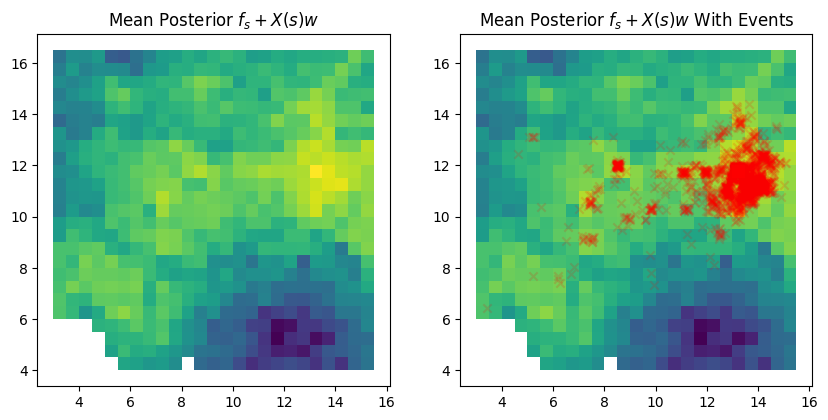

In [5]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_cov_post_mean.png',include_cov=True)